In [1]:
%%capture
!pip install -r requirements.txt

NOTE THAT: this notebook can be used to test end-to-end training pipeline. To run this notebook it is recommended to run in a GPU instance with at least 22G of RAM (such as Google Colab L4)

In [1]:
# to load and transform image datasets to tensor
from datasets import load_dataset, load_from_disk, VerificationMode
from datasets.arrow_dataset import Dataset
# diffusers model
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker

# Text processing
from transformers import CLIPTextModel, CLIPTokenizer

# Image processing
from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode

In [3]:
import os
from accelerate.utils import write_basic_config

write_basic_config()  # Write a config file
# os._exit(00)  # Restart the notebook

Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

# Note that Step 4 and beyond is carried out in SageMaker

## 4. Setup CLIP Embedding, VAE, UNET and remaining part of architecture for training
other args we can try, like whether to use EMA or not https://huggingface.co/stabilityai/stable-diffusion-2-1/discussions/22

## 6. Training loop
This train loop is referenced from Huggingface training script https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py#L912

Ref: https://huggingface.co/docs/accelerate/quicktour  


In [4]:
import torch
import torch.nn.functional as F
from accelerate import Accelerator

In [5]:
# TODO: add checkpoint and resume from checkpoint

In [15]:
from transformers import CLIPTextModel, CLIPTokenizer
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

In [6]:
def collate_fn(examples):
    """
    Collate Function is used to create a batch
    """
    pixel_values = torch.stack([torch.Tensor(example["image_tensor"]) for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([torch.Tensor(example["tokens"]).to(torch.int64) for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids}


# TODO:
A bit research on Adding noise step:
+ input_perturbation
+ noise_offset

Prediction Type: epsilon vs v_prediction
https://medium.com/@zljdanceholic/three-stable-diffusion-training-losses-x0-epsilon-and-v-prediction-126de920eb73


In [7]:
OUTPUT_DIR = "./output/stable-diffusion-finetuned"
max_train_steps=480

NOTE THAT: your parquet `train_set.parquet` should be present in the data_dir

In [8]:
train_set = load_dataset("parquet", data_dir="./data")

In [9]:
train_set = train_set["train"]

In [10]:
train_set

Dataset({
    features: ['tokens', 'image_tensor'],
    num_rows: 93
})

In [12]:
from torch.optim.lr_scheduler import ConstantLR
from transformers import CLIPTextModel, CLIPTokenizer, CLIPFeatureExtractor
from diffusers import LMSDiscreteScheduler
from accelerate.logging import get_logger
from tqdm.auto import tqdm

def train():
    # Getting the model weights from the pretrained models hub

    text_encoder = CLIPTextModel.from_pretrained("runwayml/stable-diffusion-v1-5",
                                                 subfolder="text_encoder")

    vae = AutoencoderKL.from_pretrained(
        "runwayml/stable-diffusion-v1-5", subfolder="vae"
    )

    unet = UNet2DConditionModel.from_pretrained(
        "runwayml/stable-diffusion-v1-5", subfolder="unet"
    )
    unet.enable_gradient_checkpointing()

    # Freeze vae and text_encoder (we only train the UNET)

    for params in vae.parameters():
        params.requires_grad = False

    for params in text_encoder.parameters():
        params.requires_grad = False

    vae.eval()
    text_encoder.eval()

    noise_scheduler = PNDMScheduler(beta_start=0.00085,
                                    beta_end=0.012,
                                    beta_schedule="scaled_linear",
                                    steps_offset=1,
                                    num_train_timesteps=2000,
                                    skip_prk_steps=True)


    lr = 0.01
    batch_size = 4
    optimizer = torch.optim.AdamW(unet.parameters(), lr=lr)
    lr_scheduler = ConstantLR(optimizer)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                              shuffle=True, collate_fn=collate_fn, num_workers=1)
    accelerator = Accelerator(gradient_accumulation_steps=4)
                              # mixed_precision="fp16")
    device = accelerator.device

    epochs = 10
    weight_dtype = torch.float32

    unet, optimizer, train_loader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_loader, lr_scheduler
    )

    prediction_type = "v_prediction"
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0
    # Move vae and unet to device
    vae.to(accelerator.device)
    text_encoder.to(accelerator.device)

    feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-large-patch14")

    train_loss_accum = []

    accelerator.wait_for_everyone()
    for epoch in range(epochs):
        print("EPOCH", epoch)
        # unet.train()
        train_loss = 0.0

        for step, batch in enumerate(train_loader):
            with accelerator.accumulate(unet):
                # First encode the image to laten space with the VAE encoder
                latent = vae.encode(batch["pixel_values"].to(weight_dtype)).latent_dist.sample().detach()

                latent = latent * 0.18215
                # sample noise to add to latent
                noise = torch.randn(latent.shape).to(latent.device)
                bsz = latent.shape[0]

                # Sample a random timestep for each image
                timesteps = torch.randint(0,
                                          noise_scheduler.config.num_train_timesteps,
                                          (bsz,),
                                          device=latent.device)
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latent, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual and compute loss
                model_pred = unet(noisy_latents,
                                  timesteps,
                                  encoder_hidden_states,
                                  return_dict=True)["sample"]


                loss = F.mse_loss(model_pred.float(), noise.float(), reduction="none")
                loss = loss.mean([1, 2, 3]).mean()

                # Backpropagate
                accelerator.backward(loss)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                for _ in range(accelerator.num_processes):
                    progress_bar.update(1)
                    global_step += 1

                logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
                progress_bar.set_postfix(**logs)
                accelerator.clip_grad_norm_(unet.parameters(), 1)

            if global_step >= max_train_steps:
                break
        if accelerator.is_main_process:
            train_loss_accum.append(loss.detach().item())
        accelerator.wait_for_everyone()

    # Create the pipeline using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline(
            text_encoder=accelerator.unwrap_model(text_encoder),
            vae=vae,
            unet=unet.module if accelerator.num_processes >1 else unet,
            tokenizer=tokenizer,
            scheduler=PNDMScheduler(
                beta_start=0.00085,
                steps_offset = 1,
                beta_end=0.012,
                beta_schedule="scaled_linear",
                skip_prk_steps=True
            ),
            safety_checker=None,
            feature_extractor=feature_extractor,
        )
        pipeline.save_pretrained(OUTPUT_DIR)

    accelerator.end_training()

In [13]:
from accelerate import notebook_launcher

In [14]:
notebook_launcher(train, num_processes=1)

Launching training on one GPU.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


  0%|          | 0/480 [00:00<?, ?it/s]

EPOCH 0


/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9


NameError: name 'tokenizer' is not defined

## Inferences

In [22]:
inference = StableDiffusionPipeline.from_pretrained(
    "./output/stable-diffusion-finetuned", torch_dtype=torch.float32,
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/100 [00:00<?, ?it/s]

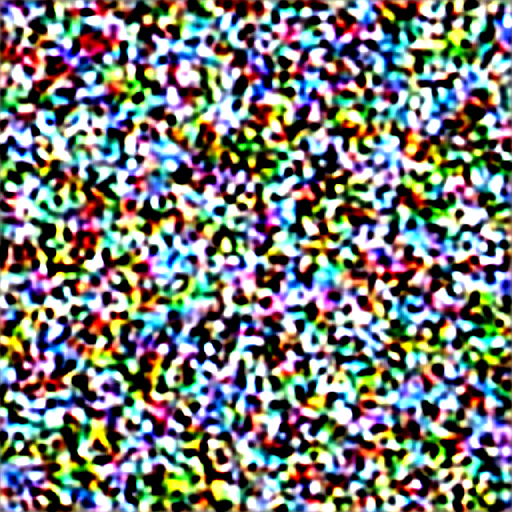

In [23]:
image = inference(
	"a portrait of a chinese immortal from Qing Dynasty", num_inference_steps=100
).images[0]
image

In [24]:
base = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float32
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

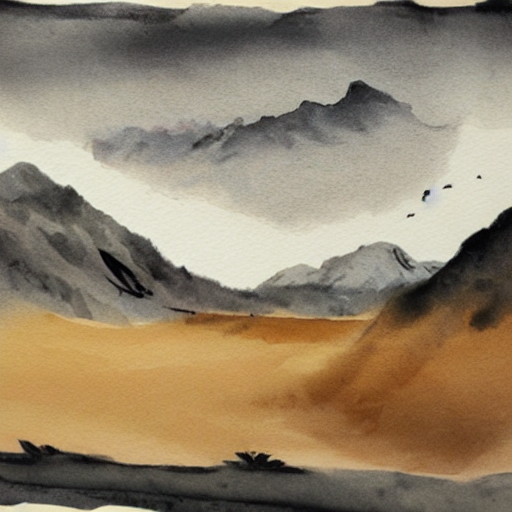

In [25]:
image_base = base(
	"mountain landscape inkwash painting style"
).images[0]
image_base